In [68]:
import geopandas as gpd 
import numpy as np 
import rasterio 
from rasterio import mask 
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from rasterio.features import geometry_mask
from shapely.geometry import box
import os
from rasterio import features


In [2]:
#Function to read vector file
def read_vector_file(shp_path: str) -> gpd.GeoDataFrame:
    """Read vector file and return GeoPandas Dataframe.

    Args:
        shp_path: Vector file path.
S
    Returns:
        shp: GeoPanda1s DataFrame.

    """
    return gpd.read_file(shp_path, mode='r')

In [3]:
vector=read_vector_file('Downloads/Task2/clustering/clipped.shp')

In [4]:
#Function to convert vector to an array type of geometry
def convert_vector_to_array(vectorfile: gpd.GeoDataFrame) -> np.ndarray:
    """Convert vector file to the array of geometry objects.

    Args:
        vectorfile: Geopandas dataframe.

    Returns:
        np.ndarray: Array of geometry objects (e.g.: polygons, multipolygons).

    """
    return np.array(vectorfile["geometry"].values)

In [6]:
geometries= convert_vector_to_array(vector)
print(geometries)

[<POLYGON ((46.132 40.86, 46.133 40.86, 46.133 40.86, 46.132 40.86, 46.132 40...>
 <POLYGON ((46.132 40.86, 46.133 40.86, 46.133 40.86, 46.132 40.86, 46.132 40...>
 <POLYGON ((46.132 40.86, 46.132 40.86, 46.132 40.86, 46.132 40.86, 46.132 40...>
 ...
 <POLYGON ((46.13 40.868, 46.13 40.868, 46.13 40.867, 46.13 40.868, 46.13 40....>
 <POLYGON ((46.128 40.886, 46.128 40.885, 46.128 40.885, 46.128 40.885, 46.12...>
 <POLYGON ((46.137 40.9, 46.138 40.899, 46.138 40.899, 46.137 40.899, 46.137 ...>]


In [7]:
# Extract coordinates from the polygons without flattening
coordinates = [np.array(geometry.exterior.coords) for geometry in geometries]

# Pad the arrays to have the same length (using NaN for padding)
max_vertices = max(len(coords) for coords in coordinates)
padded_coordinates = [
    np.pad(coords, ((0, max_vertices - len(coords)), (0, 0)), mode='constant', constant_values=np.nan)
    for coords in coordinates
]

# Convert the list of arrays to a NumPy array
X = np.array(padded_coordinates)

In [8]:
# Extract centroids from the polygons
centroids = [np.array(geometry.centroid.coords)[0] for geometry in geometries]

# Convert the list of centroids to a NumPy array
X = np.array(centroids)


In [9]:
#Data Normalization 
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
print("Original Data - Mean:", np.mean(X, axis=0), "Std Dev:", np.std(X, axis=0))
print("Normalized Data - Mean:", np.mean(X_normalized, axis=0), "Std Dev:", np.std(X_normalized, axis=0))


Original Data - Mean: [46.12533058 40.86868249] Std Dev: [0.01582743 0.01562772]
Normalized Data - Mean: [0.61290577 0.40823812] Std Dev: [0.23178013 0.25742431]


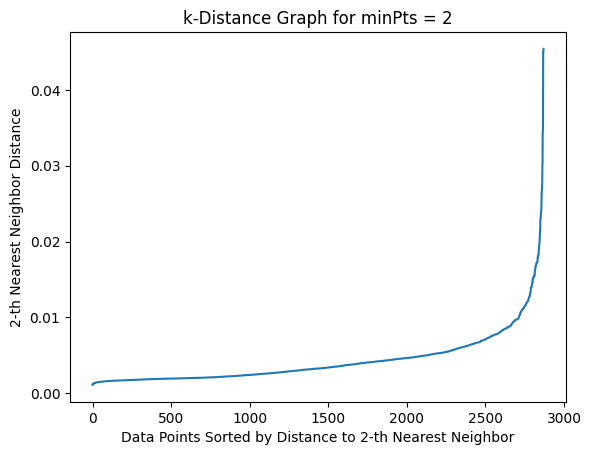

In [33]:
# Choose the value of minPts (minimum number of points in a neighborhood)
minPts = 2

# Fit a nearest neighbors model
nbrs = NearestNeighbors(n_neighbors=minPts).fit(X_normalized)

# Compute distances to minPts neighbors for each point
distances, indices = nbrs.kneighbors(X_normalized)

# Sort and plot the distances
distances = np.sort(distances[:, -1])

# Plot the k-distance graph
plt.plot(np.arange(len(distances)), distances)
plt.title(f'k-Distance Graph for minPts = {minPts}')
plt.xlabel('Data Points Sorted by Distance to {}-th Nearest Neighbor'.format(minPts))
plt.ylabel('{}-th Nearest Neighbor Distance'.format(minPts))
plt.show()

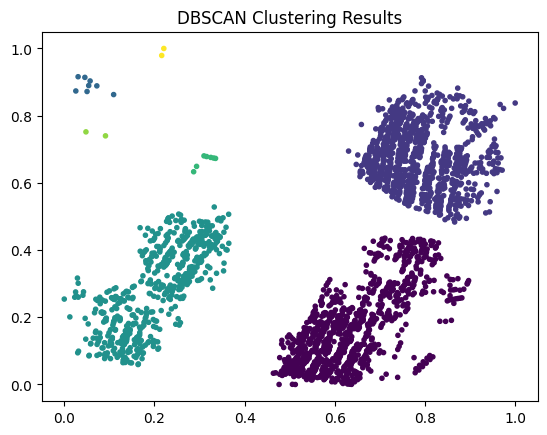

In [38]:
# Apply DBSCAN
dbscan = DBSCAN(eps=0.055, min_samples=2)
clusters = dbscan.fit_predict(X_normalized)

# Visualize the clustering results 
plt.scatter(X_normalized[:, 0], X_normalized[:, 1], c=clusters, cmap='viridis', marker='.')
plt.title('DBSCAN Clustering Results')
plt.show()

In [64]:
# Access the cluster assignments
cluster_numbers = dbscan.labels_

# 'cluster_numbers' contains the cluster assignments for each data point
print("Cluster Assignments:", cluster_numbers)

Cluster Assignments: [0 0 0 ... 0 0 0]


In [63]:
#Initializing paths 
original_shapefile_path='Downloads/Task2/clustering/clipped.shp'
original_raster_path='Downloads/Task2/clustering/test.tif'

In [100]:
def window_from_extent(xmin, xmax, ymin, ymax, transform):
    col_start, row_start = ~transform * (xmin, ymax)
    col_stop, row_stop = ~transform * (xmax, ymin)
    return ((int(row_start), int(row_stop)), (int(col_start), int(col_stop)))

# Open the original raster file
with rasterio.open(original_raster_path, mode='r') as src:
    raster_data = src.read()
    scaler_raster = MinMaxScaler()
    raster_data_normalized = scaler_raster.fit_transform(raster_data.reshape(src.count, -1)).reshape(raster_data.shape)
    
    # Iterate over unique clusters
    for cluster_id in np.unique(clusters):
        # Filter the shapefile based on the cluster
        roi_gdf = vector[clusters == cluster_id]

        # Get the bounding box of the cluster
        minx, miny, maxx, maxy = roi_gdf.total_bounds

        # Get the window from the bounding box
        window = window_from_extent(minx, maxx, miny, maxy, src.transform)

        # Apply the window to the original raster data
        arr = src.read(window=window)
        print(arr.shape)

        # Save the cropped raster to a new file
        cropped_raster_path = os.path.join('Downloads/Task2/output', f'cropped_cluster_ROI_{cluster_id}.tif')
        with rasterio.open(cropped_raster_path, 'w', **src.meta) as dst:
            dst.write(arr) 

        # Save the new shapefile
        roi_shapefile_path = os.path.join('Downloads/Task2/output', f'cropped_cluster_ROI_{cluster_id}.shp')
        # Save the new shapefile with explicit encoding
        roi_gdf.to_file(roi_shapefile_path, encoding='utf-8')



(4, 1921, 2166)
(4, 1902, 1835)
(4, 291, 525)
(4, 2091, 1882)
(4, 268, 292)
(4, 121, 294)
(4, 145, 219)
